# Saliency maps tutorial

In order to generate saliency maps, you need the dataset in the proper format (see the [prepare data tutorial](), and an architecture, trained or not (seeing saliency maps with an untrained architecture should be noise).

The first step to generating visualisation for the saliency maps will be to first compute the saliency maps.

## Generate Saliency maps

First we will set all the needed imports

In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
from meegnet.parsing import parser, save_config
from meegnet.dataloaders import Dataset
from meegnet.network import Model
from meegnet.viz import compute_saliency_maps, generate_saliency_figure
from meegnet_functions import load_single_subject

/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This next section sets up all the parameters we will need for the saliency maps computations

In [2]:
# We set up our data to be 3 channel types (MAG GRAD GRAD),
# 102 sensor locations (Elekta Neuromag Vector View 306 channel MEG),
# and 400 time samples for 800ms of signal sampled as 500Hz.
n_channels = 3
input_size = (n_channels, 102, 400)

n_outputs = 2 # using auditory vs visual stimulus classification -> 2 classes
n_subjects = 100 # For this tutorial we will only use a fraction of the data
n_samples = None # We will use all trials for each subject

# Setting up paths
save_path = "/home/arthur/data/"
model_path = save_path

clf_type = "eventclf"

Loading the model from pretrained, using the from_pretrained method, can also load another model using the load method. It is also possible to comment both lines in order to use an untrained model.

In [3]:
# setting up a seed for reproducibility (will be used for numpy, pandas, torch, and the meegnet library)
seed = 42 

# net option can be "meegnet", "eegnet" etc, see documentation
net_option = "meegnet" 

# name of the model
name = f"eventclf_{net_option}_{seed}_{n_channels}"

my_model = Model(name, net_option, input_size, n_outputs, save_path=save_path)
my_model.from_pretrained()
# my_model.load(model_path)

If the data was set-up correctly, we use participands_info.csv in order to generate a subject list and select a random subject for generating figures.

In [4]:
csv_file = os.path.join(save_path, f"participants_info.csv")
dataframe = (
    pd.read_csv(csv_file, index_col=0)
    .sample(frac=1, random_state=seed)
    .reset_index(drop=True)[: n_subjects]
)
subj_list = dataframe["sub"]
np.random.seed(seed)
random_subject_idx = np.random.choice(np.arange(len(subj_list)))

Finally, we compute the saliency maps and save them.

In [5]:
# name for the labels, will be useful for saving and generating figures
labels = ["visual", "auditory"]

# This will create a saliency maps path inside the save path
# Please don't change or it might break stuff later on
sal_path = os.path.join(save_path, "saliency_maps", name)
if not os.path.exists(sal_path):
    os.makedirs(sal_path)
    
# Only keep trials with 85% prediction confidence or more
confidence = .85

for sub in subj_list:
    dataset = Dataset(
            sfreq=500, # sampling frequency of 500Hz
            n_subjects=n_subjects,
            n_samples=n_samples,
            sensortype='ALL', # we use MAG GRAD GRAD here
            lso=True,
            random_state=seed,
    )
    dataset.load(save_path, one_sub=sub)
    compute_saliency_maps(
        dataset,
        labels,
        sub,
        sal_path,
        my_model.net,
        threshold = confidence, 
        clf_type = clf_type
    )

In [6]:
sensors = ["MAG", "PLANNAR1", "PLANNAR2"]
stim_tick = 75 # The index for the stimulus timing (150ms in a 800ms trial at 500Hz)
saliency_types = ("pos", "neg")
cmap = "coolwarm"
# Some tested aletrnatives for the colormap:
# cmap = sns.color_palette("icefire", as_cmap=True)
# cmap = sns.color_palette("coolwarm", as_cmap=True, center="dark")
# cmap = "inferno"
# cmap = "seismic"

# if raw_path if left empty, or set to None, the function will use mne Elekta vectorview 306 for sensor location 
raw_path = None

Generating figure for sensors: ['MAG', 'PLANNAR1', 'PLANNAR2']
For the eventclf classification


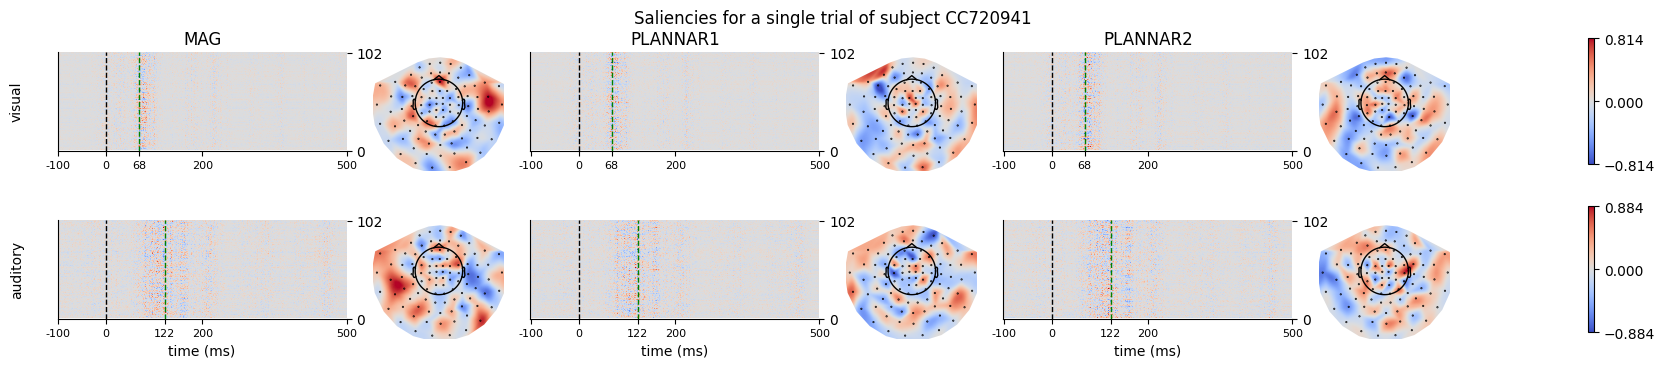

Figure generated: /home/arthur/data/eventclf_CC720941_single_trial_saliencies.png


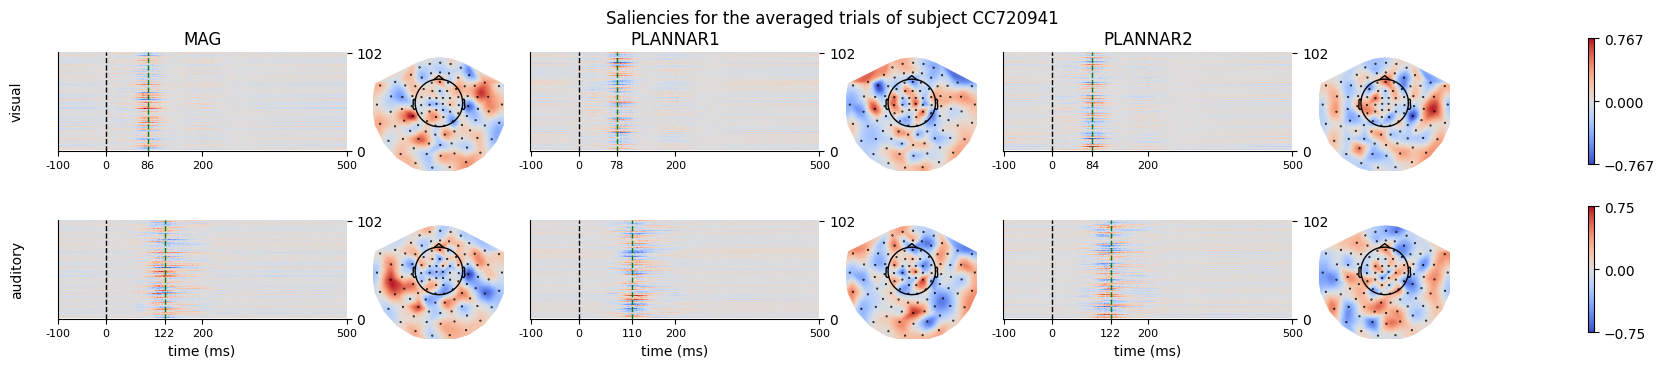

Figure generated: /home/arthur/data/eventclf_CC720941_all_trials_saliencies.png


In [ ]:
##########################
### GENERATING FIGURES ###
##########################

def get_saliency_data(saliency_dict):
    saliencies = {}
    operation = lambda a, b: a - b
    for lab, pos in saliency_dict["pos"].items():
        saliencies[lab] = operation(np.array(pos), np.array(saliency_dict["neg"][lab]))
    return saliencies

all_saliencies = defaultdict(lambda: defaultdict(lambda: []))

print(f"Generating figure for sensors: {sensors}")
print(f"For the eventclf classification")

# First load all computed saliencies
for i, sub in enumerate(subj_list):
    sub_saliencies = defaultdict(lambda: {})
    for label in labels:
        nofile = False
        for saliency_type in saliency_types:
            lab = f"_{label}"
            saliency_file = os.path.join(
                sal_path,
                f"{sub}{lab}_{saliency_type}_sal_{confidence}confidence.npy",
            )
            if os.path.exists(saliency_file):
                try:
                    saliencies = np.load(saliency_file)
                    sub_saliencies[saliency_type][label] = saliencies
                except IOError:
                    logging.warning(f"Error loading {saliency_file}")
                    nofile = True
                    continue
            else:
                nofile = True
                continue
            if len(saliencies.shape) == 3:
                saliencies = saliencies[np.newaxis, ...]  # If only one saliency in file
            elif len(saliencies.shape) != 4:
                nofile = True
                continue
            all_saliencies[saliency_type][label].append(saliencies.mean(axis=0))

        if nofile:
            continue

    skip = False
    if i == random_subject_idx:
        data_dict = get_saliency_data(sub_saliencies)
        for val in data_dict.values():
            if val.size == 0:
                skip = True
                break
        temp = {
            key: val[np.random.choice(np.arange(len(val)))]
            for key, val in data_dict.items()
        }
        out_path = generate_saliency_figure(
            temp,
            info_path=raw_path,
            save_path=save_path,
            suffix=f"{clf_type}_{sub}_single_trial",
            sensors=sensors,
            title=f"Saliencies for a single trial of subject {sub}",
            clf_type=clf_type,
            cmap=cmap,
            stim_tick=stim_tick,
            show=True,
        )
        print(f"Figure generated: {out_path}")
        temp = {key: np.mean(val, axis=0) for key, val in data_dict.items()}
        out_path = generate_saliency_figure(
            temp,
            info_path=raw_path,
            save_path=save_path,
            suffix=f"{clf_type}_{sub}_all_trials",
            sensors=sensors,
            title=f"Saliencies for the averaged trials of subject {sub}",
            clf_type=clf_type,
            cmap=cmap,
            stim_tick=stim_tick,
            show=True,
        )
        print(f"Figure generated: {out_path}")
    if skip:
        random_subject_idx += 1
        continue

for label in labels:
    for saliency_type in saliency_types:
        if type(all_saliencies[saliency_type][label]) == list:
            all_saliencies[saliency_type][label] = np.array(
                all_saliencies[saliency_type][label]
            )
            
data_dict = get_saliency_data(all_saliencies)
final_dict = {key: np.mean(val, axis=0)[np.newaxis] for key, val in data_dict.items()}

out_path = generate_saliency_figure(
    final_dict,
    info_path=raw_path,
    save_path=save_path,
    suffix=f"{clf_type}",
    sensors=sensors,
    title=f"Saliencies averaged across all subjects",
    clf_type=clf_type,
    cmap=cmap,
    stim_tick=stim_tick,
    show=True,
)
print(f"Figure generated: {out_path}")

